In [1]:
import os
import scipy.stats
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import decimal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker

In [2]:
np.random.seed(123)

Comento el código. En ## es el mío. 

In [3]:
## Tengo en la misma carpeta la notebook y el excel:
file = './Example_1.xlsx'
## levanto el excel
xl = pd.ExcelFile(file)
print(xl.sheet_names)
## me quedo con Hoja1
df1 = xl.parse('Hoja1')


['Hoja1', 'Hoja2', 'Hoja3', 'Hoja4']


In [4]:
## a ver que tiene adentro:
df1.head()

,Date,SPX,NWL,MSFT
0,2000-01-03,1441.47,72.27,47.63
1,2000-01-10,1465.15,70.53,47.98
2,2000-01-18,1441.36,70.28,44.34
3,2000-01-24,1360.16,69.53,41.99
4,2000-01-31,1424.37,70.53,45.54


In [5]:
## con pct_change obtiene el retorno, en este caso de MSFT
MSFT_ret = df1.MSFT.pct_change()

## dropea los nans 
## (en este caso solo el primer día, que no tiene como calcular la diferencia con el dia anterior) 
## y convierte en array los retornos
MSFT_ret = np.array(MSFT_ret.dropna())

## repite lo mismo para NWL
NWL_ret = df1.NWL.pct_change()
NWL_ret = np.array(NWL_ret.dropna())

## y ahora hace lo mismo para el s&p 500
SPX_ret = df1.SPX.pct_change()
SPX_ret = np.array(SPX_ret.dropna())

## este reshape lo que hace es convertir el array en un vector columna
SPX_ret = SPX_ret.reshape(-1, 1)

In [6]:
## define X como el SPX_ret (los retornos del s&p 500)
## y le agrega con add_constant un vector de 1 
## esto se hace para despues hacer una regresion, para ajustar el alfa (el intercept u ordenada)
X = sm.add_constant(SPX_ret)

## ajusta una regresion. Regresa los retornos % de MSFT contra el S&P500
## ahora cuando hacemos el print vamos a ver un cuadro con todos los estadisticos
## que nos calcula statsmodel (el paquete que estamos usando para hacer regresiones)
## const es el alfa y x1 nos da el beta del s&p500
results = sm.OLS(MSFT_ret, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     196.1
Date:                Sun, 11 Jul 2021   Prob (F-statistic):           1.80e-36
Time:                        02:24:55   Log-Likelihood:                 762.72
No. Observations:                 398   AIC:                            -1521.
Df Residuals:                     396   BIC:                            -1513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.370      0.7

In [7]:
## muestra el r cuadrado
print('Coeficiente de determinación R^2: ' + str(results.rsquared))

Coeficiente de determinación R^2: 0.3311507835612817


In [8]:
## aca muestra el riesgo específico: results.scale es SSR/(n - p) donde n es la cantidad de datos
## y p la cantidad de parámetros. SSR es la suma de residuos al cuadrado
## La raiz cuadrada de esto es el error estandar de la regresion
## TE dice, en la misma unidad de y, en promedio cuanto se aleja el modelo de los datos
## o sea que cuanto mas chico, mejor. Además, lo que tiene de piola es que te sirve
## para aproximar el intervalo de prediccion (digo el de prediccion, no el de confianza)
## que con R cuadrado no podes

## lo multiplica por la raiz cuadrada de 52 porque lo que nosotros tenemos son retornos semanales

# Specific Risk MSFT (residual standard error)
MSFT_SR = np.sqrt(results.scale)*np.sqrt(52)
print('Standard Error: Specific Risk MSFT \n' + str(MSFT_SR))

Standard Error: Specific Risk MSFT 
0.2573861544752122


In [9]:
## ahora imprime el intercept y el beta de SPX
# Params
MSFT_params = results.params
print('MSFT = Intercept ; SPX: \n' + str(MSFT_params.astype(decimal.Decimal)))

## se guarda los parametros
a_MSFT = MSFT_params[0,]
B_MSFT = MSFT_params[1,]

MSFT = Intercept ; SPX: 
[-0.0006618592810449703 1.1042103183844842]


In [10]:
## ahora repite lo mismo para NWL
# NWL
results = sm.OLS(NWL_ret, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     50.82
Date:                Sun, 11 Jul 2021   Prob (F-statistic):           4.84e-12
Time:                        02:24:55   Log-Likelihood:                 804.64
No. Observations:                 398   AIC:                            -1605.
Df Residuals:                     396   BIC:                            -1597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.224      0.0

In [11]:
## toma el r cuadrado
results.rsquared

0.11373039647490812

In [12]:
## y repite el calculo del riesgo especifico (error estandar por raiz de 52)
# Specific Risk NWL (residual standard error)
NWL_SR = np.sqrt(results.scale)*np.sqrt(52)
print('Standard Error: Specific Risk NWL \n' + str(NWL_SR))

## saca los parametros
# Params
NWL_params = results.params
print('NWL = Intercept ; SPX: \n' + str(NWL_params.astype(decimal.Decimal)))
a_NWL = NWL_params[0,]
B_NWL = NWL_params[1,]



Standard Error: Specific Risk NWL 
0.2316536214321529
NWL = Intercept ; SPX: 
[0.00358142184744622 0.505955452927042]


In [13]:
## construye un portfolio. Va a definir los pesos: 0.7 y 0.3
# Portfolio Characteristics
w_1 = 0.7
w_2 = 1-w_1

## define el alfa del portfolio como la suma pesada de los alfas que se guardó arriba
a_porfolio = w_1*a_NWL + w_2*a_MSFT
print('a_porfolio: ' + str(a_porfolio))

## define el beta del portfolio como la suma pesada de los betas que se guardó arriba
B_porfolio = w_1*B_NWL + w_2*B_MSFT
print('B_porfolio: ' + str(B_porfolio))

## define el riesgo específico del portfolio como la suma del producto 
## de los cuadrados de los riesgos específicos por los cuadrados de los pesos
SpecR_porfolio = np.sqrt(w_1**2 * NWL_SR**2 + w_2**2 * MSFT_SR**2)
print('SpecR_porfolio: ' + str(SpecR_porfolio))

a_porfolio: 0.0023084375088988627
B_porfolio: 0.6854319125642747
SpecR_porfolio: 0.17960332147398525


Text(0, 0.5, 'MSFT_ret')

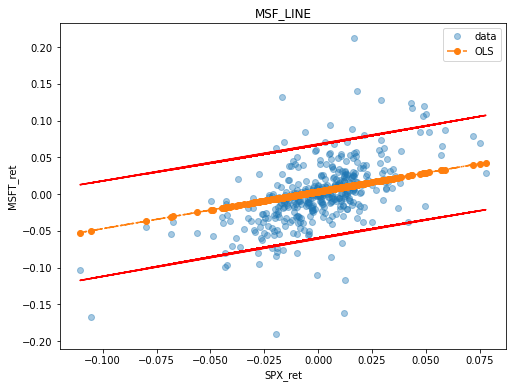

In [14]:
## aca sacamos los intervalos de prediccion 
## van a ser mucho mas anchos que los de confianza
prstd, iv_l, iv_u = wls_prediction_std(results)

## y graficamos
fig, ax = plt.subplots(figsize=(8,6))
## plotea retornos del s&p contra los retornos de msft
ax.plot(SPX_ret, MSFT_ret, 'o', label="data", alpha=0.4)
## plotea la linea de regresion
ax.plot(SPX_ret, results.fittedvalues, 'o-.', label="OLS")
## y el intervalo de prediccion
ax.plot(SPX_ret, iv_u, 'r')
ax.plot(SPX_ret, iv_l, 'r')
ax.legend(loc='best')
plt.title("MSF_LINE")
plt.xlabel("SPX_ret")
plt.ylabel("MSFT_ret")

In [15]:
## ahora levantamos hoja 2

# Assign spreadsheet filename to `file`
file = 'Example_1.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)
# Print the sheet names
print(xl.sheet_names)
# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('Hoja2')

['Hoja1', 'Hoja2', 'Hoja3', 'Hoja4']


In [16]:
## calcula retornos logaritmicos. Para eso toma el diff 
## (es la diferencia entre cada valor y el anterior)
## y a eso le calcula el logaritmo. 
## o sea. log(X(t) - X(t-1))

## calcula el reotnro para el s&p100, para amex y para cisco

# log return
SP100_ret = np.log(df1['SP100']).diff()
SP100_ret = np.array(SP100_ret.dropna())

AMEX_ret = np.log(df1['Amex']).diff()
AMEX_ret = np.array(AMEX_ret.dropna())

CISCO_ret = np.log(df1['Cisco']).diff()
CISCO_ret = np.array(CISCO_ret.dropna())



In [17]:
## tomo el s&p100 y le agrego una constante de unos p/ regresion
X = sm.add_constant(SP100_ret)

In [18]:
## regresamos los retornos de AMEX contra el s&p
# AMEX
AMEX_results = sm.OLS(AMEX_ret, X).fit()
print(AMEX_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     2071.
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          2.86e-311
Time:                        02:24:56   Log-Likelihood:                 5702.9
No. Observations:                2009   AIC:                        -1.140e+04
Df Residuals:                    2007   BIC:                        -1.139e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.554      0.5

In [19]:
## el r cuadrado de la regresion de AMEX
# R Square
AMEX_results.rsquared

0.5078061411087695

In [20]:
## igual que arriba, tomamos el riesgo específico de AMEX:
# Specific Risk AMEX (residual standard error)
AMEX_SR = np.sqrt(AMEX_results.scale)*np.sqrt(250)
print('Standard Error: Specific Risk AMEX \n' + str(AMEX_SR))

Standard Error: Specific Risk AMEX 
0.2239415444904576


In [21]:
## tomamos los parámetros
# Params
AMEX_params = AMEX_results.params
print('AMEX = Intercept ; SPX: \n' + str(AMEX_params.astype(decimal.Decimal)))
a_AMEX = AMEX_params[0,]
B_AMEX = AMEX_params[1,]

AMEX = Intercept ; SPX: 
[0.00017517661507409802 1.2400111395349356]


In [22]:
### exactamente lo mismo para cisco
# CISCO
CISCO_results = sm.OLS(CISCO_ret, X).fit()
print(CISCO_results.summary())
# R Square
CISCO_results.rsquared

# Specific Risk NWL (residual standard error)
CISCO_SR = np.sqrt(CISCO_results.scale)*np.sqrt(250)
print('Standard Error: Specific Risk CISCO \n' + str(CISCO_SR))
# Params
CISCO_params = CISCO_results.params
print('CISCO = Intercept ; SPX: \n' + str(CISCO_params.astype(decimal.Decimal)))
a_CISCO = CISCO_params[0,]
B_CISCO = CISCO_params[1,]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1534.
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          8.92e-250
Time:                        02:24:56   Log-Likelihood:                 4696.4
No. Observations:                2009   AIC:                            -9389.
Df Residuals:                    2007   BIC:                            -9378.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.424      0.6

In [23]:
## y ahora repite la construccion de portfolio que hizo más arriba
## lo que cambia son los pesos y las acciones, pero el procedimiento es el mismo

# Portfolio Characteristics
w_AMEX = 0.6
w_CISCO = 1- w_AMEX

a_porfolio = w_AMEX * a_AMEX + w_CISCO * a_CISCO
print('a_porfolio: ' + str(a_porfolio))
B_porfolio = w_AMEX * B_AMEX + w_CISCO * B_CISCO
print('B_porfolio: ' + str(B_porfolio))
SpecR_porfolio = np.sqrt(w_AMEX**2 * AMEX_SR**2 + w_CISCO**2 * CISCO_SR**2)
print('SpecR_porfolio: ' + str(SpecR_porfolio))

a_porfolio: 1.6651539794187878e-05
B_porfolio: 1.4486266341166045
SpecR_porfolio: 0.19976830762368897


In [24]:
#### PORTFOLIO CONSTANT WEIGHTS RETURNS

## acá define los retornos del portfolio (pesos por retornos)
PORFT_Const_W_Ret = w_AMEX * AMEX_ret + w_CISCO * CISCO_ret

## y regresa el portfolio contra el mercado
PORTF_CW_results = sm.OLS(PORFT_Const_W_Ret, X).fit()
print(PORTF_CW_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     4284.
Date:                Sun, 11 Jul 2021   Prob (F-statistic):               0.00
Time:                        02:24:56   Log-Likelihood:                 6120.7
No. Observations:                2009   AIC:                        -1.224e+04
Df Residuals:                    2007   BIC:                        -1.223e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.665e-05      0.000      0.065      0.9

In [25]:
## mira el r cuadrado de la regresion del portfolio contra el mercado
# R Square
PORTF_CW_results.rsquared

0.6809560849258582

In [26]:
## y analiza el riestgo específico del portfolio
# Specific Risk NWL (residual standard error)
PORTF_CW_SR = np.sqrt(PORTF_CW_results.scale)*np.sqrt(250)
print('Standard Error: Specific Risk PORTF_CW \n' + str(PORTF_CW_SR))

Standard Error: Specific Risk PORTF_CW 
0.18189137574237382


In [27]:
## se queda con los parámetros
# Params
PORTF_CW_params = PORTF_CW_results.params
print('PORTF_CW = Intercept ; SPX: \n' + str(PORTF_CW_params.astype(decimal.Decimal)))
a_PORTF_CW = PORTF_CW_params[0,]
B_PORTF_CW = PORTF_CW_params[1,]



PORTF_CW = Intercept ; SPX: 
[1.665153979418739e-05 1.4486266341166059]


In [28]:
## ahora va a hacer un EWMA
Lambda = 0.95 ## define lambda

## calcula los retornos del portfolio con amex y cisco
PORTF_ret = AMEX_ret * w_AMEX + CISCO_ret * (1-w_AMEX)


## hace el producto de los retornos de s&100 con los retornos de amex
SP100_AMEX = SP100_ret * AMEX_ret
## repite para cisco
SP100_CISCO = SP100_ret * CISCO_ret
## y repite para el portfolio
SP100_PORTF = SP100_ret * PORTF_ret

## a todo lo eleva al cuadrado
SP100_2 = SP100_ret**2
AMEX_2 = AMEX_ret**2
CISCO_2 = CISCO_ret**2
PORTF_2 = PORTF_ret**2

In [29]:
## aca lo que calcula la covarianza usando ewma 
## es la formula de la pagina 34 de "parte 2"
## lambda * cov(t-1) + (1-lambda) * retorno_s&p(t-1) * retorno_accion(t-1)

## define un primer elemento de la lista
EWMA_Cov_SP100_AMEX = [0.0001]
## y va iterando: hace el calculo con el elemento de la lista anterior y despues
## agrega el resultado a la lista, como para en el siguiente paso tomarlo:
## arranca por el valor que le define (0.0001), hace el calculo y  guarda el rdo en la lista.
## en la iteración dos, agarra este valor nuevo (el resultado anterior), hace el calculo y lo guarda en la lista
## y así.
for i in range(len(df1['SP100'])-1):
    EWMA_Cov_SP100_AMEX.append(Lambda * EWMA_Cov_SP100_AMEX[i] + (1-Lambda) * SP100_AMEX[i])
print(EWMA_Cov_SP100_AMEX[-1])

EWMA_Cov_SP100_CISCO = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Cov_SP100_CISCO.append(Lambda * EWMA_Cov_SP100_CISCO[i] + (1-Lambda) * SP100_CISCO[i])
print(EWMA_Cov_SP100_CISCO[-1])

## aca en vez de accion, el segundo término es con retorno_s&p(t-1) * retorno_portfolio(t-1)
EWMA_Cov_PORTF_CISCO = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Cov_PORTF_CISCO.append(Lambda * EWMA_Cov_PORTF_CISCO[i] + (1-Lambda) * SP100_PORTF[i])
print(EWMA_Cov_PORTF_CISCO[-1])


0.0002029879226996217
0.00014415682427000042
0.00017945548332777317


In [30]:
## y acá lo que calcula es la varianza por ewma
## la logica es la misma, define un primer valor en una lista
## usa ese valor para el cálculo de la varianza, y lo guarda en esa misma lista.
## en la siguiente iteración toma ese último valor calculado y trabaja con él. 

## lo que cambia es la fórmula que ahora es la de la varianza:
## lambda * sigma(t-1)**2 + (1-lambda) * retorno_acción(t-1)**2

EWMA_Var_SP100 = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Var_SP100.append(Lambda * EWMA_Var_SP100[i] + (1-Lambda) * SP100_2[i])

EWMA_Var_AMEX = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Var_AMEX.append(Lambda * EWMA_Var_AMEX[i] + (1-Lambda) * AMEX_2[i])

EWMA_Var_CISCO = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Var_CISCO.append(Lambda * EWMA_Var_CISCO[i] + (1-Lambda) * CISCO_2[i])

EWMA_Var_PORTF = [0.0001]
for i in range(len(df1['SP100'])-1):
    EWMA_Var_PORTF.append(Lambda * EWMA_Var_PORTF[i] + (1-Lambda) * PORTF_2[i])

print(EWMA_Var_SP100[-1])
print(EWMA_Var_AMEX[-1])
print(EWMA_Var_CISCO[-1])
print(EWMA_Var_PORTF[-1])

0.00013789377030709417
0.0005562577717000374
0.00035583182389002893
0.00033512023440289266


In [31]:
## calculas los betas: la covarianza entre s&p100 y cada accion (o el portfolio) 
## dividido la varianza dle s&p 100
EWMA_Beta_AMEX = np.asarray(EWMA_Cov_SP100_AMEX) / np.asarray(EWMA_Var_SP100)
EWMA_Beta_CISCO = np.asarray(EWMA_Cov_SP100_CISCO) / np.asarray(EWMA_Var_SP100)
EWMA_BETA = np.asarray(EWMA_Cov_PORTF_CISCO) / np.asarray(EWMA_Var_SP100)

In [32]:
## calcula el riesgo sistemático (formula en pagina 39 de "parte 2")
## es el beta * la raiz cuadrada de la varianza * la raiz cuadrada de h
Systematic_Risk = np.asarray(EWMA_BETA) * np.sqrt(np.asarray(EWMA_Var_SP100)*250)

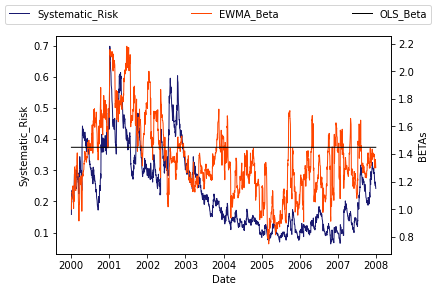

In [33]:
## repite el beta de ols del portfolio
## esto es para graficar el beta contra le tiempo y que le quede una constante

OLS_B = np.repeat(B_PORTF_CW, len(df1['SP100']))
OLS_B = np.asarray(OLS_B)

## Acá repr
fig, ax = plt.subplots()
ax.plot(df1['Date'], Systematic_Risk, label="Systematic_Risk", color="midnightblue", lw=1)
# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
ax2.plot(df1['Date'], EWMA_BETA, label="EWMA_Beta", color='orangered', lw=1)
ax2.plot(df1['Date'], OLS_B, label="OLS_Beta", color='black', lw=1)

ax.set_xlabel("Date")
ax.set_ylabel(r"Systematic_Risk")
ax2.set_ylabel(r"BETAs")
#plt.legend(loc='lower left', mode="expand")
fig.legend(loc='upper center', mode="expand",  ncol=3)



In [34]:
##este es el ejercicio de la página 24
## La volatilidad de una acción es del 25%. Un modelo lineal con dos factores de riesgo indica que la acción
## tiene 2 betas de 0.8 y 1.2. Asimismo los factores de riesgo tienen una volatilidad del 15% y 20%
## respectivamente y una correlación de −0.5.

## ¿Qué parte de la volatilidad de la acción se puede atribuir a los factores de riesgo y qué tan grande es el
## riesgo específico de la acción?

# Inputs
## define los betas de los factores y su volatilidad. Además, la correlación de los factores de riesgo
## y la volatilidad de la accion

beta_1 = 0.8 
beta_2 = 1.2
RiskF1_vol = 0.15
RiskF2_vol = 0.20
RiskF_corr = -0.5
Portf_Vol = 0.25

## calcula la matriz de covarianzas de factores de riesgo
# Covariance Matrix
Cov_Mtrx = np.array([[RiskF1_vol**2, RiskF1_vol * RiskF2_vol * RiskF_corr],[RiskF1_vol * RiskF2_vol * RiskF_corr, RiskF2_vol**2]])
print(Cov_Mtrx)

[[ 0.0225 -0.015 ]
 [-0.015   0.04  ]]


In [35]:
# Risk Decomposition
## estos son los betas
Factors_vector = np.array([beta_1,beta_2])
print(Factors_vector)

[0.8 1.2]


In [36]:
## La varianza de la acción debido a los factores de riesgo es:
FactorsVar = np.dot(np.dot(Cov_Mtrx , Factors_vector.transpose()),Factors_vector)  ## Variance due to factors
print(FactorsVar)

0.0432


In [37]:
## y si quiero el desvío estándar:
FactorsVol = np.sqrt(FactorsVar)    ## Volatility due to factors
print(FactorsVol)

0.20784609690826528


In [38]:
## Si varianza total = var sistemática + var específica, 
## descomponemos la varianza total del 25% ** 2 = 0.0625(Portfol_vol **2)
## como:
## 0.0625=0.0432 + 0.0193. Por lo tanto la volatilidad específica del activo es raíz(0.019) = 13.89%

SpecR = np.sqrt(Portf_Vol**2 - FactorsVar)    ## Specific risk
print(SpecR)


## En resumen, la volatilidad de la acción del 25% se puede descomponer en dos, 20,78% debido a los factores
## de riesgo y 13,89% de volatilidad idiosincrásica (riesgo específico)

0.13892443989449804


In [39]:
## que pasa si en vez de 1 activo tenemos varios?
## el codigo es muy parecido al anterior:

# Inputs
## defino los weights de los activos y los betas de cada uno para los dos factores:
weights123 = np.array([-0.25, 0.75, 0.5])
Beta1_123 = np.array([0.2, 0.9, 1.3])
Beta2_123 = np.array([1.2, 0.2, 0.7])
RiskFactor1_vol = 0.15
RiskFactor2_vol = 0.2
RiskF_Corr= -0.5

# Net Betas
## multiplica los betas por los pesos
Factor1 = np.dot(Beta1_123, weights123.transpose())
Factor2 = np.dot(Beta2_123, weights123.transpose())

## y genera un array con ambos factores
Factors = np.array([Factor1, Factor2])

## matriz de var y cov:
# Covariance Matrix
CovM = [[RiskFactor1_vol**2, RiskFactor1_vol*RiskFactor2_vol*RiskF_Corr],[RiskFactor1_vol*RiskFactor2_vol*RiskF_Corr, RiskFactor2_vol**2]]


# Outputs
Result = np.dot(np.dot(CovM , Factors.transpose()),Factors)

SystematicRisk = np.sqrt(Result)
print(SystematicRisk)

0.1747185236315829


In [40]:
# Modelos multifactoriales con tenencias internacionales:
# Ejemplo descomposición de Riesgo Sistemático en factores de Acciones y FX

## define a manopla la data de input
## este es el ejercicio de la pagina 82 de "PARTE 2"

# Holding
P_FTSE100 = 2.5
P_SP500 = 1
P_Dax30 = 1.5
P_USDGBP = 1
P_EURGBP = 1.5
TOTAL_POSI = P_FTSE100 + P_SP500 + P_Dax30

B_FTSE100 = 1.5
B_SP500 = 1.2
B_Dax30 = 0.8
B_USDGBP = 1
B_EURGBP = 1

Vol_FTSE100 = 0.2
Vol_SP500 = 0.22
Vol_Dax30 = 0.25
Vol_USDGBP = 0.1
Vol_EURGBP = 0.12

Volatilities = np.array([0.2, 0.22, 0.25, 0.1, 0.12])
Vol_MTRX = np.diag(Volatilities)
print (Vol_MTRX)

[[0.2  0.   0.   0.   0.  ]
 [0.   0.22 0.   0.   0.  ]
 [0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.12]]


In [41]:
## define a mano una matriz de correlacion

Correlations = [1, 0.8, 1, 0.7, 0.6, 1, 0.2, -0.25, 0.05, 1, 0.3, 0.05, -0.15, 0.6, 1]
Corr_MTRX = [
    [1.0, 0.8, 0.7, 0.2, 0.3],
    [0.8, 1.0, 0.6, -0.25, 0.05],
    [0.7, 0.6, 1.0, 0.05, -0.15],
    [0.2, -0.25, 0.05, 1.0, 0.6],
    [0.3, 0.05, -0.15, 0.6, 1.0]]

## hace producto de matriz de correlacion con las volatilidades que definió arriba
## obtiene acá la matriz de la pagina 84:
# Covariance
COV_MTRX = np.dot(np.dot(Vol_MTRX, Corr_MTRX),Vol_MTRX)
print(COV_MTRX)

[[ 0.04     0.0352   0.035    0.004    0.0072 ]
 [ 0.0352   0.0484   0.033   -0.0055   0.00132]
 [ 0.035    0.033    0.0625   0.00125 -0.0045 ]
 [ 0.004   -0.0055   0.00125  0.01     0.0072 ]
 [ 0.0072   0.00132 -0.0045   0.0072   0.0144 ]]


In [42]:
## calcula los weights del ftse100, sp500 y dax30 (divide contra el total de la posición)
w = np.array([P_FTSE100 / TOTAL_POSI, P_SP500 / TOTAL_POSI, P_Dax30 / TOTAL_POSI])

## ahora va a calcular la varianza systematica (p.84)

## define la matriz de betas
Beta_MTRX = [
    [1.5, 0, 0],
    [0, 1.2, 0],
    [0, 0, 0.8],
    [0, 1.0, 0],
    [0, 0, 1.0]]

## y hace el producto con los weights 
## esto lo va a usar en un ratito para valcular la varianza sistematica
Bw = np.dot(Beta_MTRX,w.transpose())
print(Bw)

## y con esto ya tiene para calcular varianza sistemática
## como en la primera ecuacion de la página 84 (abajo a derecha)
Systematic_Variance = np.dot(np.dot(COV_MTRX, Bw.transpose()),Bw)
print(Systematic_Variance)

[0.75 0.24 0.24 0.2  0.3 ]
0.06409552


In [43]:
## le saca la raiz para tener el desvío:
Systematic_Risk = Systematic_Variance**0.5
print(Systematic_Risk)

0.25317093040078675


In [44]:
## riesgo de fx: 
print(COV_MTRX[3:5,3:5])

[[0.01   0.0072]
 [0.0072 0.0144]]


In [45]:
## vector de betas
print(Bw[0:3])

[0.75 0.24 0.24]


In [46]:
## vector de weights
print(w[1:3])

[0.2 0.3]


In [47]:
## y acá calcula el riesgo de equity:
## (Equity variance, la segunda ecuacion de p.84)
Equity_Variance = np.dot(np.dot(COV_MTRX[0:3,0:3], Bw[0:3].transpose()),Bw[0:3])
Equity_Risk = Equity_Variance**0.5
print(Equity_Risk)

0.24075182242300888


In [48]:
## fx variance, esta es la 3ra ecuacion de p.84
FX_Variance = np.dot(np.dot(COV_MTRX[3:5,3:5], w[1:3].transpose()),w[1:3])
FX_Risk = FX_Variance**0.5
print(FX_Risk)


## define esto en 0 (¿?)
Quanto_Covariance = 0
Quanto_Risk = 0

0.05059644256269407


In [49]:
###################
# Caso de estudio #
###################

### va a reproducir el gráfico de p.85

## acá levanta al data:
# Assign spreadsheet filename to `file`
file = 'Example_1.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)
# Print the sheet names
print(xl.sheet_names)
# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('Hoja4')

['Hoja1', 'Hoja2', 'Hoja3', 'Hoja4']


In [52]:
# rebase

## droplea la columna Date
df1_aux = df1.drop(df1.columns[[0]], axis=1, inplace=False)

## multiplica todos los valores por 100 
## Y divide todos los valores de cada columna por el primer valor de esa columna.
## entonces te dice, para cada valor, que % representa respecto del primer valor.
perf_rb = df1_aux * 100 / (df1_aux['Vodafone'][0], df1_aux['Nokia'][0], df1_aux['NYSE Index'][0], df1_aux['Communications'][0], df1_aux['Growth'][0], df1_aux['Large Cap'][0])

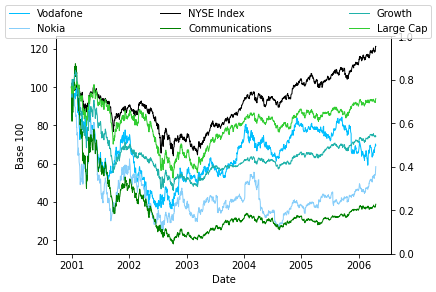

In [53]:
## y plotea los valores de recién. Lo que vemos es como cambian los valores respecto al primer valor.
## El priemr valor es el 100% y de ahí se va moviendo

## PLOT     #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
fig, ax = plt.subplots()
ax.plot(df1['Date'], perf_rb['Vodafone'], label="Vodafone", color="deepskyblue", lw=1)
ax.plot(df1['Date'], perf_rb['Nokia'], label="Nokia", color="lightskyblue", lw=1)
ax.plot(df1['Date'], perf_rb['NYSE Index'], label="NYSE Index", color="black", lw=1)
ax.plot(df1['Date'], perf_rb['Communications'], label="Communications", color="green", lw=1)
ax.plot(df1['Date'], perf_rb['Growth'], label="Growth", color="lightseagreen", lw=1)
ax.plot(df1['Date'], perf_rb['Large Cap'], label="Large Cap", color="limegreen", lw=1)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
#ax2.plot(df1['Date'], EWMA_BETA, label="EWMA_Beta", color='orangered', lw=1)
#ax2.plot(df1['Date'], OLS_B, label="OLS_Beta", color='black', lw=1)

ax.set_xlabel("Date")
ax.set_ylabel(r"Base 100")
#plt.legend(loc='lower left', mode="expand")
fig.legend(loc='upper center', mode="expand",  ncol=3)


In [54]:
##########
# PART A #
##########

# log return
## calcula los retornos log: toma el diff (diferencia respecto al valor anterior)
## y calcula el logaritmo.
## eso lo pasa a array y dropea los nans.
## Esto lo hace para vodafone y para nokia
Vodafone_ret = np.log(df1['Vodafone']).diff()
Vodafone_ret = np.array(Vodafone_ret.dropna())
Nokia_ret = np.log(df1['Nokia']).diff()
Nokia_ret = np.array(Nokia_ret.dropna())

# Weights
## define un peso de 1 para vodafone y de 3 para nokia
Vodafone_P = 1
Nokia_P = 3
## y lo divide por la suma para que sean pesos posta (o sea, que sumen 1)
w_Vodafone = Vodafone_P / (Vodafone_P + Nokia_P)
w_Nokia = 1- w_Vodafone

## define el retorno del portfolio (pesos x retornos)
Portfolio_ret = Vodafone_ret * w_Vodafone + Nokia_ret * w_Nokia

## y el desvío del portfolio
Portf_StDev = np.std(Portfolio_ret)
## anual:
Portf_Volatility = np.sqrt(250)*Portf_StDev
print(str(Portf_Volatility*100)+'%')


42.53180198061199%


In [55]:
##########
# PART B #
##########

## define log returns para vodafone, nokia y NYSE
## tmb tiene communications, growth y LCap que son factores
## creo que comos los que vimos con Siri
# log return
Vodafone_ret = np.log(df1['Vodafone']).diff()
Vodafone_ret = np.array(Vodafone_ret.dropna())
Nokia_ret = np.log(df1['Nokia']).diff()
Nokia_ret = np.array(Nokia_ret.dropna())
NYSE_ret = np.log(df1['NYSE Index']).diff()
NYSE_ret = np.array(NYSE_ret.dropna())
Comm_ret = np.log(df1['Communications']).diff()
Comm_ret = np.array(Comm_ret.dropna())
Growth_ret = np.log(df1['Growth']).diff()
Growth_ret = np.array(Growth_ret.dropna())
LCap_ret = np.log(df1['Large Cap']).diff()
LCap_ret = np.array(LCap_ret.dropna())

In [56]:
##  concatenamos los factores (NYSE que es mercado, communications, growth y LCap que supongo es large cap)
# Nokia 4 factors
Four_Factors = np.vstack((NYSE_ret, Comm_ret, Growth_ret, LCap_ret)).T

## agregamos columna de 1 para intercept
X = sm.add_constant(Four_Factors)

In [57]:
## regresamos los retornos de Nokia (ojo que acá regresamos retornos, con siri regresabamos exceso)
Nokia_results = sm.OLS(Nokia_ret, X).fit()
print(Nokia_results.summary(xname=['Const', 'NYSE_ret', 'Comm_ret', 'Growth_ret', 'LCap_ret']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     283.3
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          4.32e-176
Time:                        02:25:22   Log-Likelihood:                 3143.4
No. Observations:                1331   AIC:                            -6277.
Df Residuals:                    1326   BIC:                            -6251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const      -7.398e-05      0.001     -0.118      0.9

In [58]:
## printeamos el R cuadrado (no el ajustado) y la correlación
print(Nokia_results.rsquared, Nokia_results.rsquared**0.5)
# R2 squared (or) Multiple R. is the correlation coefficient. It tells you how strong the linear relationship is.

0.46080267049502266 0.6788244769415895


In [59]:
## y aca printeamos los parámetros (también los podríamos ver de arriba, del summary)
# Params
Nokia_Betas = Nokia_results.params
print('Const: ' + str(Nokia_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'NYSE_ret: ' + str(Nokia_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'Comm_ret: ' + str(Nokia_Betas[2,].astype(decimal.Decimal)) +
      '\n' + 'Growth_ret: ' + str(Nokia_Betas[3,].astype(decimal.Decimal)) +
      '\n' + 'LCap_ret: ' + str(Nokia_Betas[4,].astype(decimal.Decimal)))

Const: -7.397826103185176e-05
NYSE_ret: -0.26743828722303936
Comm_ret: 0.27053274389164206
Growth_ret: 0.2003417756431091
LCap_ret: 1.146053374446805


In [60]:
## Ahora repite para vodafone!
# Vodafone 4 factors
Four_Factors = np.vstack((NYSE_ret, Comm_ret, Growth_ret, LCap_ret)).T

X = sm.add_constant(Four_Factors)

Vodafone_results = sm.OLS(Vodafone_ret, X).fit()
print(Vodafone_results.summary(xname=['Const', 'NYSE_ret', 'Comm_ret', 'Growth_ret', 'LCap_ret']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     175.8
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          7.33e-121
Time:                        02:25:23   Log-Likelihood:                 3362.9
No. Observations:                1331   AIC:                            -6716.
Df Residuals:                    1326   BIC:                            -6690.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0002      0.001     -0.467      0.6

In [61]:
## R y R cuadrado para vodafone
print(Vodafone_results.rsquared, Vodafone_results.rsquared**0.5)



0.34651380654739594 0.5886542334404773


In [62]:
## parametros para vodafone
# Params
Vodafone_Betas = Vodafone_results.params
print('Const: ' + str(Vodafone_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'NYSE_ret: ' + str(Vodafone_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'Comm_ret: ' + str(Vodafone_Betas[2,].astype(decimal.Decimal)) +
      '\n' + 'Growth_ret: ' + str(Vodafone_Betas[3,].astype(decimal.Decimal)) +
      '\n' + 'LCap_ret: ' + str(Vodafone_Betas[4,].astype(decimal.Decimal)))


Const: -0.0002487205857213451
NYSE_ret: 0.8565539150929808
Comm_ret: 0.13729806704753275
Growth_ret: 0.22360462074617765
LCap_ret: 0.009236109287933947


In [63]:
###################
# Portfolio_Betas #
###################

## junta los betas de nokia y vodafone
## en Nokia_Vodafone_Betas tiene 2 columnas (una para nokia y uno para vodafone)
## y una fila para cada factor de riesgo 
Nokia_Vodafone_Betas = np.vstack((Nokia_Betas[1:,], Vodafone_Betas[1:,])).T

## concatena los weights
weights = np.vstack((w_Nokia, w_Vodafone))

## hace el producto de los betas por los pesos
Portfolio_Betas = np.dot(Nokia_Vodafone_Betas, weights)

In [64]:
from sklearn.covariance import EmpiricalCovariance


## EmpiricalCovariance es el estimador de maxima verosimilitud de la matriz de covarianza
## lo usa para calcular la matriz de covarianza de la matriz de factores
cov = EmpiricalCovariance().fit(Four_Factors)
Risk_Factor_Cov_Matrix = cov.covariance_

## para calcular le riesgo sistemático hace: Betas_traspuesto * cov * Betas
## (Ver página 89, en la diapo la matriz de cov es omega)
Systematic_Risk_Variance = np.dot(Portfolio_Betas.transpose(),np.dot(Risk_Factor_Cov_Matrix, Portfolio_Betas))
## como es anual lo multiplica por 250 y le saca la raiz a todo
Systematic_Risk_Volatility = (Systematic_Risk_Variance*250)**0.5

## entonces, el riesgo sistemático es de:
print(Systematic_Risk_Volatility)

[[0.30322629]]


In [65]:
## y ahora va a clacular el riesgo sistematico por PCA:
# PCA
## va a pedirle 4 componentes
pca = PCA(n_components=4)
## y ajusta el pca
pca.fit(Four_Factors)
print(pca.explained_variance_ratio_) ## ratio de varianza explicada por cada componente
## fijate que le primer componente te explica + del 90% de variabilidad
print(pca.singular_values_) ## los valores singulares

[0.90247054 0.07435621 0.0160072  0.00716605]
[1.13961836 0.32711583 0.15177511 0.10155066]


In [66]:
## transforma las variables
X_pca = pca.transform(Four_Factors) # convertimos nuestros datos con las nuevas dimensiones de PCA
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl) ## variabilidad explicada por cada componente (%)
print('suma:',sum(expl[0:2]))
#Vemos que con 2 componentes tenemos algo mas del 97% de varianza explicada


shape of X_pca (1331, 4)
[0.90247054 0.07435621 0.0160072  0.00716605]
suma: 0.9768267549937071


Text(0, 0.5, 'cumulative explained variance')

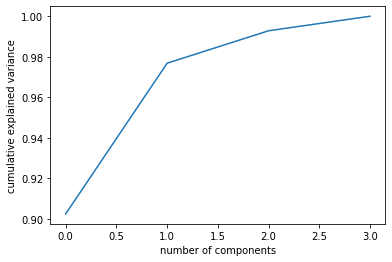

In [67]:
# graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [68]:
## Ojo que está tomando todos los componentes, acá no baja la dimensionalidad ni se pierde información
## la ventaja de lo que se está haciendo acá es obtener un nuevo juego de variables que sean ortogonales entre sí
## o sea, descorrelacionaste todo.

In [69]:
## agrega un vector de 1 a las 4 componentes
# Regression 4 PC
X_PCA = sm.add_constant(X_pca)

# Nokia 4 factors
## y regresa los retornos de nokia contra los 4 componentes de PCA
Nokia_results = sm.OLS(Nokia_ret, X_PCA).fit()
print(Nokia_results.summary(xname=['Const', 'PC1', 'PC2', 'PC3', 'PC4']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     283.3
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          4.32e-176
Time:                        02:25:23   Log-Likelihood:                 3143.4
No. Observations:                1331   AIC:                            -6277.
Df Residuals:                    1326   BIC:                            -6251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0004      0.001     -0.644      0.5

In [70]:
## muestra el R cuadrado y el R
print(Nokia_results.rsquared, Nokia_results.rsquared**0.5)
# R2 squared (or) Multiple R. is the correlation coefficient. It tells you how strong the linear relationship is.

0.46080267049502266 0.6788244769415895


In [71]:
## y muestra los betas de cada componente
# Params
Nokia_Betas = Nokia_results.params
print('Const: ' + str(Nokia_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'PC1: ' + str(Nokia_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'PC2: ' + str(Nokia_Betas[2,].astype(decimal.Decimal)) +
      '\n' + 'PC3: ' + str(Nokia_Betas[3,].astype(decimal.Decimal)) +
      '\n' + 'PC4: ' + str(Nokia_Betas[4,].astype(decimal.Decimal)))


Const: -0.0004033623583010285
PC1: 0.6625967216896244
PC2: 0.2941803201385804
PC3: -0.41944720267180424
PC4: 0.8926219440273708


In [72]:
## ahora repite para vodafone:

# Vodafone 4 factors
Vodafone_results = sm.OLS(Vodafone_ret, X_PCA).fit()
print(Vodafone_results.summary(xname=['Const', 'PC1', 'PC2', 'PC3', 'PC4']))
print(Vodafone_results.rsquared, Vodafone_results.rsquared**0.5)
# R2 squared (or) Multiple R. is the correlation coefficient. It tells you how strong the linear relationship is.

# Params
Vodafone_Betas = Vodafone_results.params
print('Const: ' + str(Vodafone_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'PC1: ' + str(Vodafone_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'PC2: ' + str(Vodafone_Betas[2,].astype(decimal.Decimal)) +
      '\n' + 'PC3: ' + str(Vodafone_Betas[3,].astype(decimal.Decimal)) +
      '\n' + 'PC4: ' + str(Vodafone_Betas[4,].astype(decimal.Decimal)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     175.8
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          7.33e-121
Time:                        02:25:23   Log-Likelihood:                 3362.9
No. Observations:                1331   AIC:                            -6716.
Df Residuals:                    1326   BIC:                            -6690.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0003      0.001     -0.514      0.6

In [73]:
## Ahora lo que va a hacer es repetir el análisis pero solo con dos factores en vez de los 4
## va a tomar los primeros 2 (97% variabilidad explicada!)
# Regression 2 PC
# Nokia 2 factors
## regresa retornos de nokia contra esos 2 factores
Nokia_results = sm.OLS(Nokia_ret, X_PCA[:,0:3]).fit()
print(Nokia_results.summary(xname=['Const', 'PC1', 'PC2']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     546.0
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          8.83e-174
Time:                        02:25:23   Log-Likelihood:                 3131.7
No. Observations:                1331   AIC:                            -6257.
Df Residuals:                    1328   BIC:                            -6242.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0004      0.001     -0.639      0.5

In [74]:
## r cuadrado y r
print(Nokia_results.rsquared, Nokia_results.rsquared**0.5)
# R2 squared (or) Multiple R. is the correlation coefficient. It tells you how strong the linear relationship is.


0.4512476848139688 0.6717497188789653


In [75]:
## parametros
# Params
Nokia_Betas = Nokia_results.params
print('Const: ' + str(Nokia_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'PC1: ' + str(Nokia_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'PC2: ' + str(Nokia_Betas[2,].astype(decimal.Decimal)))

Const: -0.00040336235830102757
PC1: 0.662596721689625
PC2: 0.294180320138579


In [76]:
## repite lo mismo con vodafone
# Vodafone 2 factors
Vodafone_results = sm.OLS(Vodafone_ret, X_PCA[:,0:3]).fit()
print(Vodafone_results.summary(xname=['Const', 'PC1', 'PC2']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     344.3
Date:                Sun, 11 Jul 2021   Prob (F-statistic):          3.38e-121
Time:                        02:25:23   Log-Likelihood:                 3357.8
No. Observations:                1331   AIC:                            -6710.
Df Residuals:                    1328   BIC:                            -6694.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0003      0.001     -0.512      0.6

In [77]:
## r cuadrado y r

print(Vodafone_results.rsquared, Vodafone_results.rsquared**0.5)
# R2 squared (or) Multiple R. is the correlation coefficient. It tells you how strong the linear relationship is.

0.34148218724384893 0.5843647724186057


In [78]:
## parametros
# Params
Vodafone_Betas = Vodafone_results.params
print('Const: ' + str(Vodafone_Betas[0,].astype(decimal.Decimal)) +
      '\n' + 'PC1: ' + str(Vodafone_Betas[1,].astype(decimal.Decimal)) +
      '\n' + 'PC2: ' + str(Vodafone_Betas[2,].astype(decimal.Decimal)))

Const: -0.0002727569493651188
PC1: 0.4230433206478674
PC2: 0.50903194514017
